In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants
import astropy

deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

au_to_R_sun = (constants.au / constants.R_sun).value # conversion constant

In [4]:
def get_arrays(asciiTable, errDict=None, jitter=False):
    """
    Reformat ascii tables into pure numpy arrays of the right dimension.
    """
    
    output = []
    
    for star in ["Aa", "Ab"]:
    
        # get the RVs 
        rv = asciiTable["RV_" + star]
        
        if type(rv) is astropy.table.column.MaskedColumn:
            mask = ~rv.mask # values we want to keep when indexing
        else:
            mask = np.ones(len(rv), dtype="bool")

        rv = np.ascontiguousarray(rv[mask])
        date = np.ascontiguousarray(asciiTable["HJD"][mask])
        
        if errDict is None:
            err = np.ascontiguousarray(asciiTable["sigma_" + star][mask])
        else:
            err = np.ones(len(date), dtype=np.float64) * errDict[star]
            
        if jitter:
            err = np.ones(len(date), dtype=np.float64) * 0.1 # [km/s] assume a small error, since we'll infer.

        assert len(date) == len(rv), "date - rv length mismatch"
        assert len(date) == len(err), "date - err length mismatch"
            
        tup = (date, rv, err)

        output.append(tup)

    return output
    
    
# Do this to infer w/ jitter 
jitter=True

# load all the data
data_cfa = ascii.read("data/cfa.dat")
# cfa errors are provided in table 
cfa1,cfa2 = get_arrays(data_cfa, jitter=jitter)

data_keck = ascii.read("data/keck.dat", format="tab", fill_values=[("X", 0)])
err_keck = {"Aa":0.63, "Ab":0.85, "B":0.59} # km/s
keck1,keck2 = get_arrays(data_keck, err_keck, jitter=jitter)

data_feros = ascii.read("data/feros.dat")
err_feros = {"Aa":2.61, "Ab":3.59, "B":2.60} # km/s
feros1,feros2 = get_arrays(data_feros, err_feros, jitter=jitter)

data_dupont = ascii.read("data/dupont.dat", fill_values=[("X", 0)])
err_dupont = {"Aa":1.46, "Ab":2.34, "B":3.95} # km/s
dupont1,dupont2 = get_arrays(data_dupont, err_dupont, jitter=jitter)

data = [data_cfa, data_keck, data_feros, data_dupont]

# date is HJD + 2400000

In [5]:
# load the astrometric data
# keep in mind that the primary and secondary stars *could* be switched
# separation is in milliarcseconds
int_data = ascii.read("data/int_data.dat")

astro_jd = int_data["epoch"][0] - 2400000
rho_data = int_data["sep"][0] * 1e-3 # arcsec
rho_err = int_data["sep_err"][0] * 1e-3 # arcsec 
theta_data = int_data["pa"][0] * deg # radians
theta_err = int_data["pa_err"][0] * deg # radians

In [7]:
# load the exoplanet part 
import pymc3 as pm 
import theano.tensor as tt

import corner

import exoplanet as xo
from exoplanet.distributions import Angle

In [18]:
# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

xs_phase = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=27.31, sd=0.12) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec

    a_ang = pm.Uniform("a_ang", 0.1, 10.0, testval=3.51) # milliarcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", 1e-3 * a_ang / parallax) # au
    
    logP = pm.Uniform("logP", lower=0, upper=np.log(50.0),
                      testval=np.log(34.87846)) # days
    P = pm.Deterministic("P", tt.exp(logP))
    
    e = pm.Uniform("e", lower=0, upper=1, testval=0.62)
    omega = Angle("omega", testval=80.5 * deg) # omega_Aa
    Omega = Angle("Omega", testval=110.0 * deg) # - pi to pi # estimated assuming same as CB disk
    gamma = pm.Uniform("gamma", lower=0, upper=20, testval=10.1) # km/s
    
    # uniform on cos incl. testpoint assuming same as CB disk.
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(140.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
#     a_print = tt.printing.Print('a_ang')(a)

    # Since we're doing an RV + astrometric fit, M2 now becomes a parameter of the model
    MAb = pm.Normal("MAb", mu=0.3, sd=0.5) # solar masses
    
    t_periastron = pm.Uniform("tPeri", lower=52690.0, upper=52720., testval=52704.55) # + 2400000 days

    
    orbit = xo.orbits.KeplerianOrbit(a=a*au_to_R_sun, period=P, ecc=e, t_periastron=t_periastron, 
                                     omega=omega, Omega=Omega, incl=incl, m_planet=MAb)

        
    # now that we have a physical scale defined, the total mass of the system makes sense
    MA = pm.Deterministic("MA", orbit.m_total)
    MAa = pm.Deterministic("MAa", MA - MAb)
    
    
    # since we have 4 instruments, we need to predict 4 different dataseries
    def get_RVs(t1, t2, offset):
        """
        Helper function for RVs. 

        Args:
            t1: times to query for star 1
            t2 : times to query for star 2
            offset: (km/s)
            
        Returns:
            (rv1, rv2) [km/s] evaluated at those times with offset applied
       """
        # get the RV predictions
        # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, so we only need the v_z vector
        # but, note that since +Z points towards the observer, we actually want v_radial = -v_Z (see conv)
        rv1 = conv * orbit.get_star_velocity(t1)[2] + gamma + offset
        rv2 = conv * orbit.get_planet_velocity(t2)[2] + gamma + offset
        
        return (rv1, rv2)
    

    offset_keck = pm.Normal("offsetKeck", mu=0.0, sd=5.0) # km/s
    offset_feros = pm.Normal("offsetFeros", mu=0.0, sd=5.0) # km/s
    offset_dupont = pm.Normal("offsetDupont", mu=0.0, sd=5.0) # km/s

    # expects m/s
    # dates are the first entry in each tuple of (date, rv, err)
    rv1_cfa, rv2_cfa = get_RVs(cfa1[0], cfa2[0], 0.0)
    rv1_keck, rv2_keck = get_RVs(keck1[0], keck2[0], offset_keck)
    rv1_feros, rv2_feros = get_RVs(feros1[0], feros2[0], offset_feros)
    rv1_dupont, rv2_dupont = get_RVs(dupont1[0], dupont2[0], offset_dupont)
    
    logjit_cfa = pm.Uniform("logjittercfa", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_keck = pm.Uniform("logjitterkeck", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_feros = pm.Uniform("logjitterferos", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_dupont = pm.Uniform("logjitterdupont", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    jit_cfa = pm.Deterministic("jitCfa", tt.exp(logjit_cfa))
    jit_keck = pm.Deterministic("jitKeck", tt.exp(logjit_keck))
    jit_feros = pm.Deterministic("jitFeros", tt.exp(logjit_feros))
    jit_dupont = pm.Deterministic("jitDupont", tt.exp(logjit_dupont))
    
    # get the total errors
    def get_err(rv_err, logjitter):
        return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
    
    # define the RV likelihoods
    pm.Normal("cfaRV1Obs", mu=rv1_cfa, observed=cfa1[1], sd=get_err(cfa1[2], logjit_cfa))
    pm.Normal("cfaRV2Obs", mu=rv2_cfa, observed=cfa2[1], sd=get_err(cfa2[2], logjit_cfa))
    pm.Normal("keckRV1Obs", mu=rv1_keck, observed=keck1[1], sd=get_err(keck1[2], logjit_keck))
    pm.Normal("keckRV2Obs", mu=rv2_keck, observed=keck2[1], sd=get_err(keck2[2], logjit_keck))
    pm.Normal("ferosRV1Obs", mu=rv1_feros, observed=feros1[1], sd=get_err(feros1[2], logjit_feros))
    pm.Normal("ferosRV2Obs", mu=rv2_feros, observed=feros2[1], sd=get_err(feros2[2], logjit_feros))
    pm.Normal("dupontRV1Obs", mu=rv1_dupont, observed=dupont1[1], sd=get_err(dupont1[2], logjit_dupont))
    pm.Normal("dupontRV2Obs", mu=rv2_dupont, observed=dupont2[1], sd=get_err(dupont2[2], logjit_dupont))
    
    
    # get the astrometric predictions
    # since there is only one measurement no jitter 
    rho_model, theta_model = orbit.get_relative_angles(astro_jd, parallax) # arcsec
        

    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)) # wrap-safe
    pm.Normal("obs_theta", mu=theta_diff, observed=0.0, sd=theta_err)

        
    # Compute the phased RV signal
#     # phased since periastron 
    
#     t_dense = xs_phase * P + t_periastron 

#     rv1, rv2 = get_RVs(t_dense, t_dense, 0.0)
    
#     rv1_dense = pm.Deterministic("RV1Dense", rv1)
#     rv2_dense = pm.Deterministic("RV2Dense", rv2)

    
    


In [19]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logjitterdupont_interval__', 'logjitterferos_interval__', 'logjitterkeck_interval__', 'logjittercfa_interval__', 'offsetDupont', 'offsetFeros', 'offsetKeck', 'tPeri_interval__', 'MAb', 'cosIncl_interval__', 'gamma_interval__', 'Omega_angle__', 'omega_angle__', 'e_interval__', 'logP_interval__', 'a_ang_interval__', 'mparallax']
message: Desired error not necessarily achieved due to precision loss.
logp: -25257.020977462318 -> -267.0856685914277


In [12]:
map_sol

{'mparallax': array(27.31119957),
 'a_ang_interval__': array(0.09969072),
 'logP_interval__': array(2.28873309),
 'e_interval__': array(0.53200075),
 'omega_angle__': array([4.42208904, 0.66717962]),
 'Omega_angle__': array([ 4.12375222, -1.73051093]),
 'gamma_interval__': array(-0.02935457),
 'cosIncl_interval__': array(1.97041383),
 'MAb': array(0.36544172),
 'tPeri_interval__': array(-0.05440562),
 'offsetKeck': array(-1.24317787),
 'offsetFeros': array(1.27912882),
 'offsetDupont': array(-0.17165726),
 'logjittercfa_interval__': array(1.85213677),
 'logjitterkeck_interval__': array(0.58133979),
 'logjitterferos_interval__': array(1.64151539),
 'logjitterdupont_interval__': array(1.20797108),
 'parallax': array(0.0273112),
 'a_ang': array(5.29653039),
 'a': array(0.19393254),
 'logP': array(3.55188064),
 'P': array(34.87885048),
 'e': array(0.62994963),
 'omega': array(1.42105142),
 'Omega': array(1.96812229),
 'gamma': array(9.85323769),
 'cosIncl': array(0.75531111),
 'incl': arra

In [20]:
sampler = xo.PyMC3Sampler(window=100, finish=500)
with model:
    burnin = sampler.tune(tune=2500, step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 2008/2008 [01:55<00:00,  5.52draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterdupont, logjitterferos, logjitterkeck, logjittercfa, offsetDupont, offsetFeros, offsetKeck, tPeri, MAb, cosIncl, gamma, Omega, omega, e, logP, a_ang, mparallax]
Sampling 4 chains: 100%|██████████| 12000/12000 [14:43<00:00,  4.72draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
pm.summary(trace)

mean        sd      mc_error       hpd_2.5  \
mparallax           27.311389  0.120465  1.009545e-03     27.071597   
MAb                  0.443460  0.198425  2.951798e-03      0.099831   
offsetKeck          -1.248506  0.489847  4.270994e-03     -2.223455   
offsetFeros          1.270574  1.010122  9.048769e-03     -0.673674   
offsetDupont        -0.176758  0.695404  5.642356e-03     -1.530791   
parallax             0.027311  0.000120  1.009545e-06      0.027072   
a_ang                5.520875  0.854753  1.291092e-02      3.805513   
a                    0.202147  0.031293  4.723976e-04      0.139919   
logP                 3.551881  0.000030  3.020359e-07      3.551820   
P                   34.878853  0.001045  1.053460e-05     34.876739   
e                    0.630754  0.007012  6.525373e-05      0.617054   
omega                1.418017  0.022666  2.199600e-04      1.375350   
Omega                1.880759  0.182717  7.000877e-03      1.524514   
gamma                9.857769  0.450986  4.006690e-03      8.979877   
cosIncl             -0.068437  0.753740  6.602193e-02     -0.864201   
incl                 1.649755  0.869703  7.587831e-02      0.526156   
tPeri            52704.576371  0.073010  6.343620e-04  52704.430708   
MA                   0.970772  0.434353  6.467357e-03      0.216165   
MAa                  0.527312  0.236052  3.516154e-03      0.116291   
logjittercfa         1.336950  0.088754  7.894447e-04      1.171876   
logjitterkeck       -0.143331  0.175686  2.005955e-03     -0.466780   
logjitterferos       1.238293  0.205254  2.312777e-03      0.853018   
logjitterdupont      0.705334  0.194133  2.192484e-03      0.347621   
jitCfa               3.822539  0.343376  3.199440e-03      3.169095   
jitKeck              0.880214  0.160636  1.929047e-03      0.599757   
jitFeros             3.525566  0.770347  1.004032e-02      2.300730   
jitDupont            2.064305  0.426355  5.519247e-03      1.349647   

                     hpd_97.5         n_eff      Rhat  
mparallax           27.541846  14492.634532  1.000099  
MAb                  0.812796   4028.512923  1.000263  
offsetKeck          -0.317309  13401.159498  1.000120  
offsetFeros          3.325504  11392.018878  0.999940  
offsetDupont         1.186373  11463.154219  0.999903  
parallax             0.027542  14492.634532  1.000099  
a_ang                7.225843   3977.797455  1.000254  
a                    0.265118   3969.614886  1.000274  
logP                 3.551938  10789.645931  0.999971  
P                   34.880848  10789.705094  0.999971  
e                    0.644609  12653.144346  0.999852  
omega                1.464488  10420.166817  0.999947  
Omega                2.239644    232.455306  1.012769  
gamma               10.731654  13337.714530  1.000179  
cosIncl              0.864744     29.832514  1.078767  
incl                 2.614357     29.966896  1.078077  
tPeri            52704.716957  10935.348680  1.000005  
MA                   1.776615   4024.091570  1.000254  
MAa                  0.962215   4023.514689  1.000246  
logjittercfa         1.518674  11718.458417  0.999941  
logjitterkeck        0.213790   8815.190350  0.999850  
logjitterferos       1.635231   7573.161423  1.000029  
logjitterdupont      1.094977   9356.310109  1.000683  
jitCfa               4.491670  10900.648757  0.999951  
jitKeck              1.200348   8068.400316  0.999848  
jitFeros             5.072248   5664.322128  1.000134  
jitDupont            2.893857   7205.446600  1.000831

/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25968ba8>,
      dtype=object)

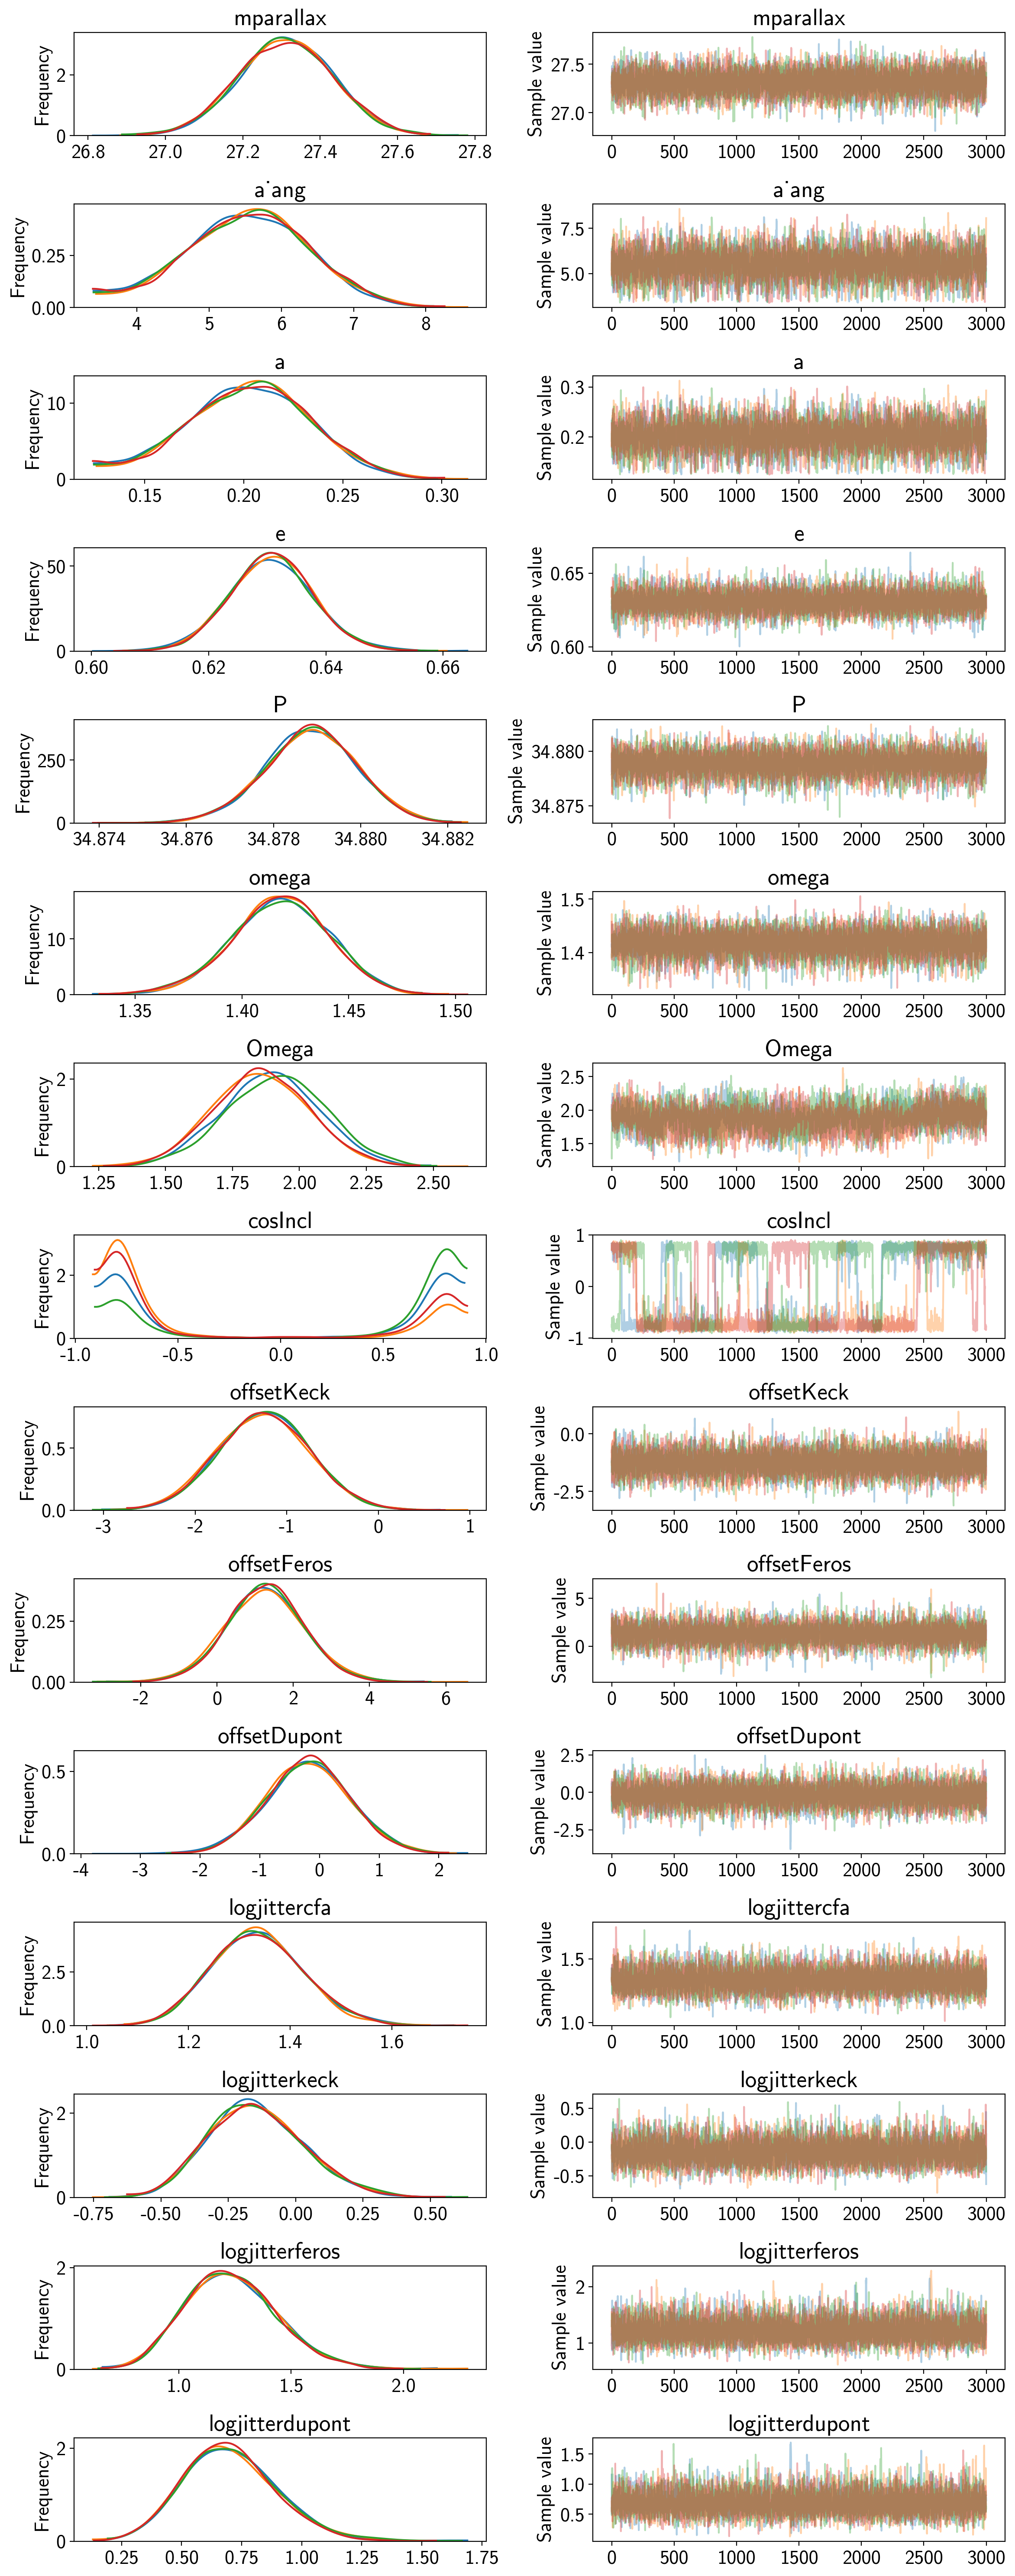

In [22]:
pm.traceplot(trace, varnames=["mparallax", "a_ang", "a", "e", "P", "omega", "Omega", "cosIncl",
                              "offsetKeck", "offsetFeros", "offsetDupont", 
                              "logjittercfa", "logjitterkeck", "logjitterferos", "logjitterdupont"])

To assess the quality of the fit, we should go and plot the fit and residuals for all of the data points individually and together.

The phase-folding plot only really works for a fixed value of `tperi`, `P`. So, we can plot the MAP phase fold. But other than that it only makes sense to plot the orbit scatter on the actual series of points (minus any offset, too). 

KeyError: 'RV1Dense'

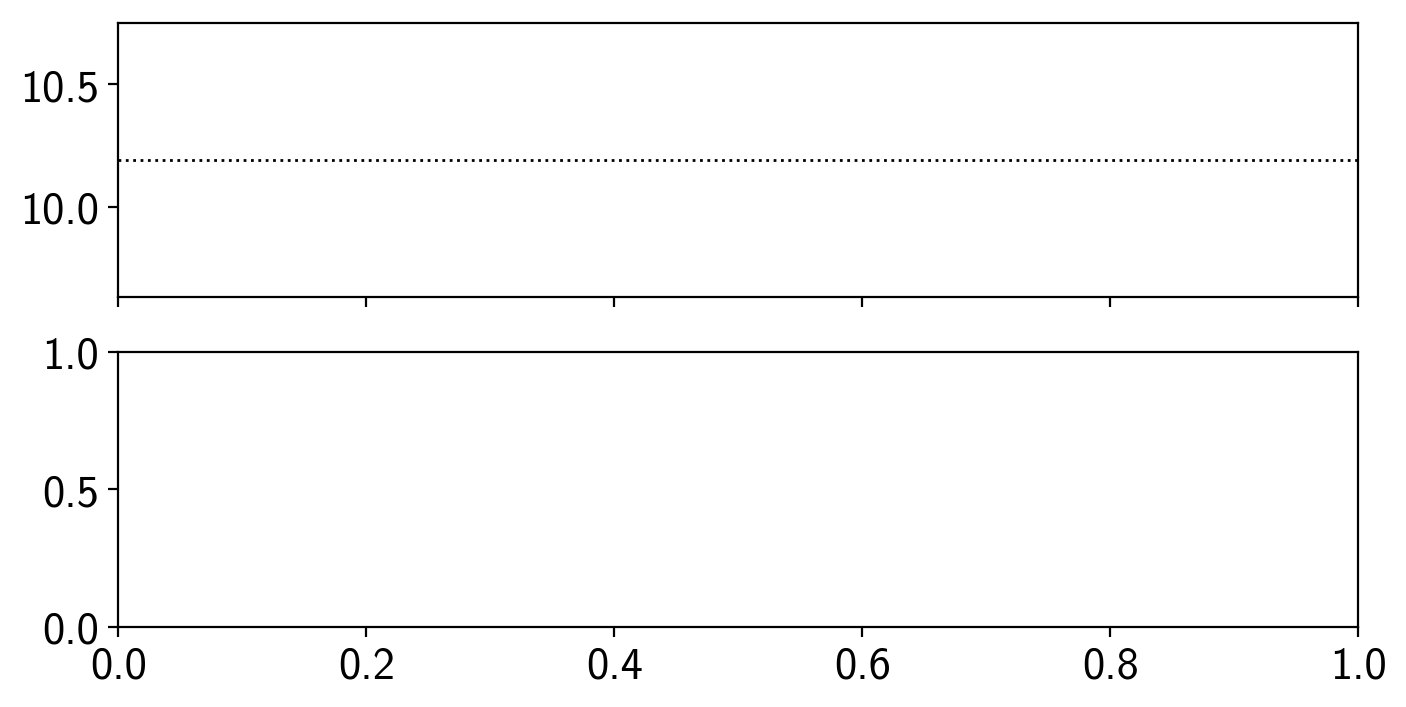

In [23]:
# plot everything ontop in a single plot

pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ms":5.0, "ls":"", "elinewidth":1.2}

def get_phase(dates, pos):
    return ((dates - pos["tPeri"]) % pos["P"]) / pos["P"]

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(43)
choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,4))

with model:
    
    pos = trace[choice] 

    tperi = pos["tPeri"]
    P = pos["P"]

    # calculate the errors for each instrument
    cfa_err1 = np.sqrt(cfa1[2]**2 + np.exp(2 * pos["logjittercfa"]))
    cfa_err2 = np.sqrt(cfa2[2]**2 + np.exp(2 * pos["logjittercfa"]))
    
    keck_err1 = np.sqrt(keck1[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    keck_err2 = np.sqrt(keck2[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    
    feros_err1 = np.sqrt(feros1[2]**2 + np.exp(2 * pos["logjitterferos"]))
    feros_err2 = np.sqrt(feros2[2]**2 + np.exp(2 * pos["logjitterferos"]))
    
    dupont_err1 = np.sqrt(dupont1[2]**2 + np.exp(2 * pos["logjitterdupont"]))
    dupont_err2 = np.sqrt(dupont2[2]**2 + np.exp(2 * pos["logjitterdupont"]))
        
    # plot RV1 model
    ax[0].axhline(pos["gamma"], lw=1.0, color="k", ls=":")
    ax[0].plot(xs_phase, pos["RV1Dense"], zorder=-1)
    
    # at data locations
    ax[0].errorbar(get_phase(cfa1[0], pos), cfa1[1], yerr=cfa_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(keck1[0], pos), keck1[1] - pos["offsetKeck"], yerr=keck_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(feros1[0], pos), feros1[1] - pos["offsetFeros"], yerr=feros_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(dupont1[0], pos), dupont1[1] - pos["offsetDupont"], yerr=dupont_err1, **ekw, zorder=0)
    
    # plot RV2
    ax[1].axhline(pos["gamma"], lw=1.0, color="k", ls=":")
    ax[1].plot(xs_phase, pos["RV2Dense"], zorder=-1)
    
    # at data locations
    ax[1].errorbar(get_phase(cfa2[0], pos), cfa2[1], yerr=cfa_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(keck2[0], pos), keck2[1] - pos["offsetKeck"], yerr=keck_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(feros2[0], pos), feros2[1] - pos["offsetFeros"], yerr=feros_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(dupont2[0], pos), dupont2[1] - pos["offsetDupont"], yerr=dupont_err2, **ekw, zorder=0)

    ax[1].set_xlim(0.0, 1.0)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_xlabel("phase")
    
fig.subplots_adjust(top=0.98, bottom=0.18, hspace=0.05)
fig.savefig("A_sb_orbit.pdf")

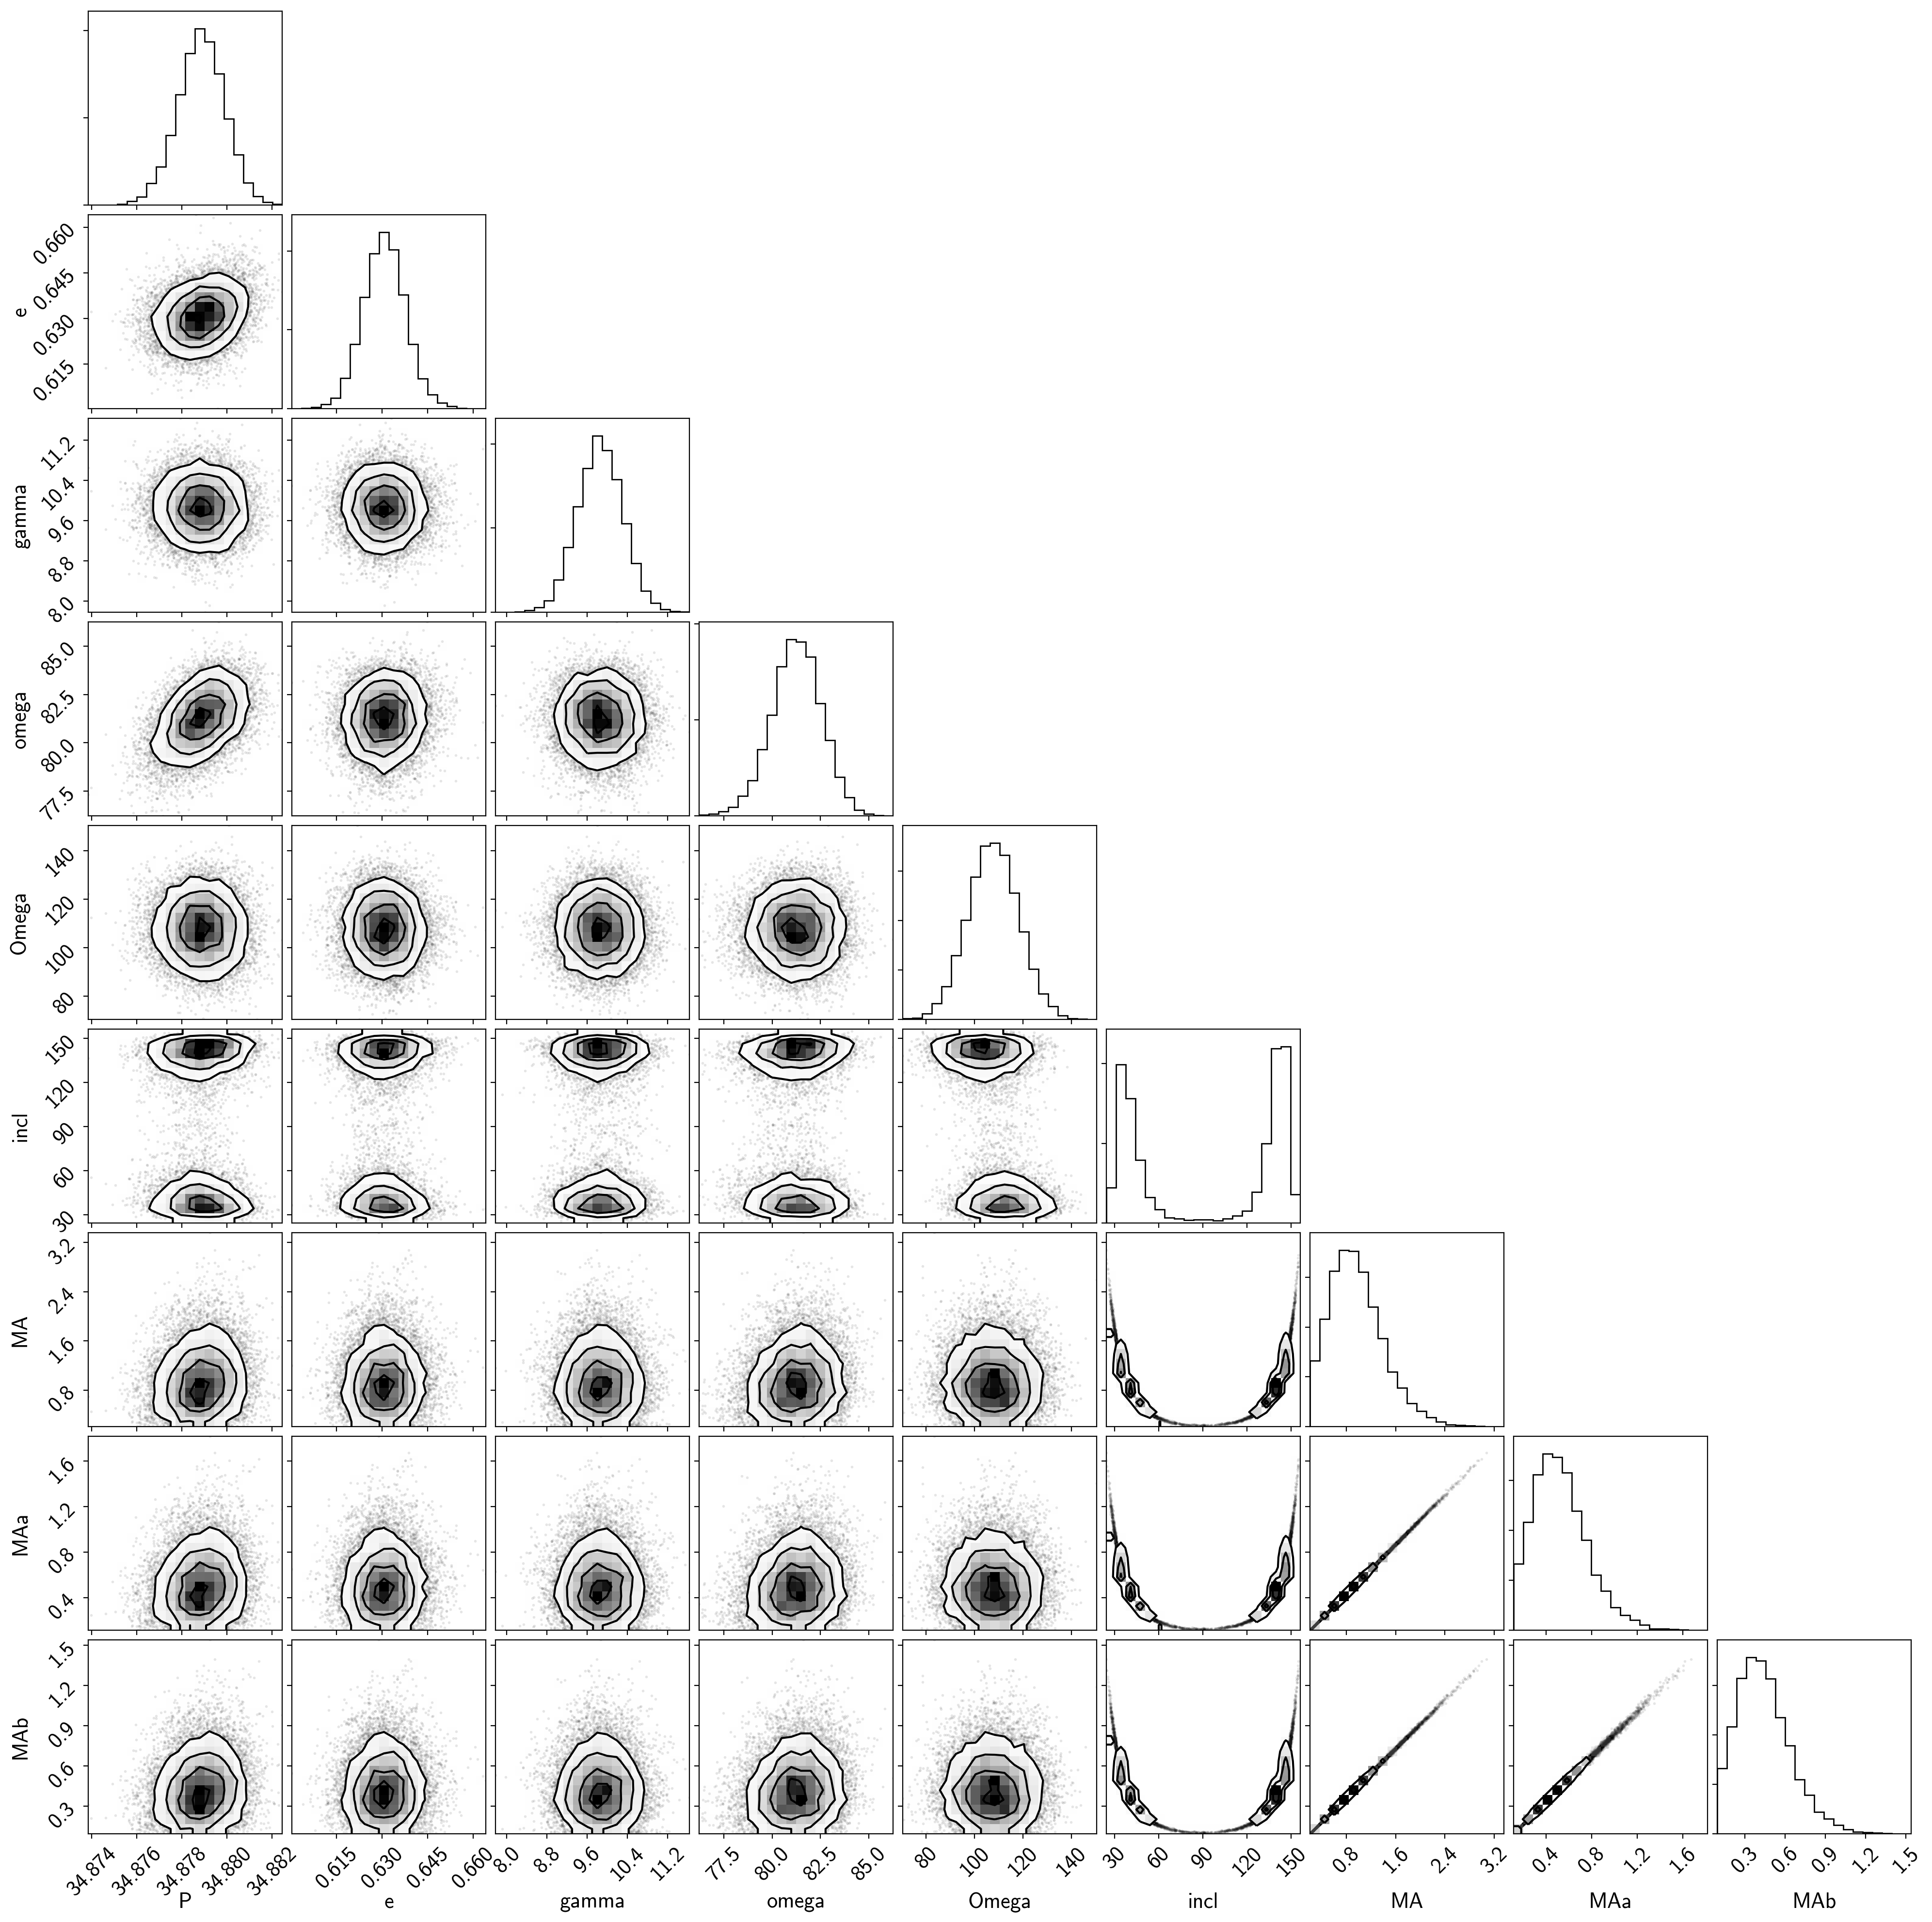

In [25]:
samples = pm.trace_to_dataframe(trace, varnames=["P", "e", "gamma", "omega", "Omega", "incl", 
                                                 "MA", "MAa", "MAb"])
samples["omega"] /= deg
samples["Omega"] /= deg
samples["incl"] /= deg
corner.corner(samples);